# Imaging basics

In this notebook, we'll use the microscope gym API to perform basic imaging tasks like acquiring an image and moving the stage. We'll use the `mock_scope` microscope emulator, but the same commands should also work with any microscope adaptor that implements the microscope gym API.


In [1]:
from microscope_gym.microscope_adapters.mock_scope import microscope_factory
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imread
import stackview

## Setting up a `mock_scope`

### Read the overview image that represents the entire sample

the mock_scope will later capture parts of this as the camera image

cl.OCLArray([[12857., 12095., 12748., ..., 10954., 12440., 12282.],
       [10402., 12988., 11687., ..., 12728., 14038., 12839.],
       [12199., 12239., 11810., ..., 13232., 12005., 11433.],
       ...,
       [14868., 13607., 12815., ..., 12374., 11965., 11034.],
       [11650., 13004., 13011., ..., 10943., 11881., 10532.],
       [14918., 12612., 13623., ..., 10996., 11870., 12409.]],
      dtype=float32)
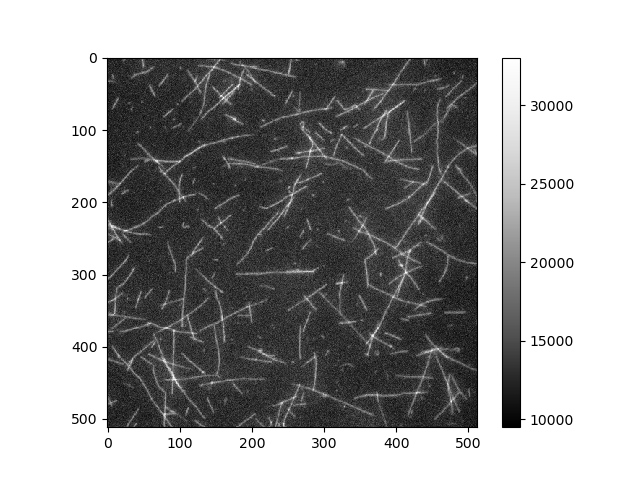
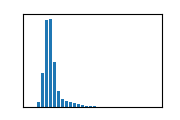

In [2]:
overview_image = imread("data/microtubules.tif")
overview_image[4]

### Initialize the microscope

In [3]:
mock_scope = microscope_factory(overview_image=overview_image, camera_height_pixels=64, camera_width_pixels=64)
print('overview_image shape: ', mock_scope.camera.overview_image.shape)
print('camera height: ', mock_scope.camera.height_pixels)
print('camera width: ', mock_scope.camera.width_pixels)
print('stage position: ', mock_scope.get_stage_position())

overview_image shape:  (11, 512, 512)
camera height:  64
camera width:  64
stage position:  (5.5, 256.0, 256.0)


## Using the microscope

### Taking an image

cl.OCLArray([[15404., 14873., 15862., ..., 13498., 14376., 13104.],
       [14537., 14288., 17721., ..., 14128., 13809., 13770.],
       [14903., 16802., 20437., ..., 13335., 14088., 12621.],
       ...,
       [14882., 14058., 13633., ..., 12124., 13162., 12039.],
       [12035., 13802., 11661., ..., 13148., 15788., 13187.],
       [12831., 14662., 12883., ..., 13801., 13465., 12933.]],
      dtype=float32)
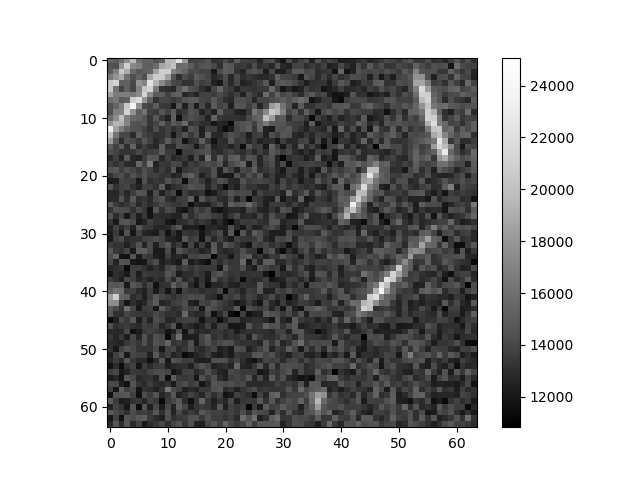
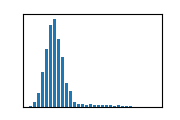

In [4]:
cle.asarray(mock_scope.acquire_image())

Note that this image is from the center of the entire overview_image - the starting position of the stage.

### Taking a z-stack

In [5]:
stackview.slice(mock_scope.acquire_z_stack(), zoom_factor=6)


### Relative stage movement

We move the stage up by half a field-of-view and take another image

stage position:  (5.5, 224.0, 256.0)


cl.OCLArray([[13328., 13575., 13977., ..., 14256., 13600., 12600.],
       [12209., 13732., 12806., ..., 12608., 13558., 13423.],
       [12501., 13257., 13102., ..., 13103., 15599., 14333.],
       ...,
       [12559., 13782., 12865., ..., 14213., 14454., 13890.],
       [12381., 13472., 12036., ..., 13521., 13827., 12685.],
       [12070., 13703., 14194., ..., 13107., 13367., 12681.]],
      dtype=float32)
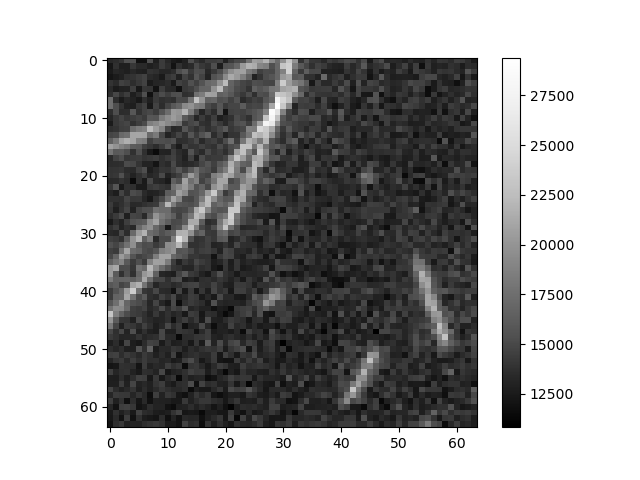
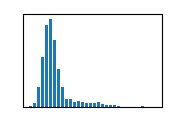

In [6]:
mock_scope.move_stage_by(relative_y_position=-32)
print('stage position: ', mock_scope.get_stage_position())
cle.asarray(mock_scope.acquire_image())


### Absolute stage movement

We move the stage to the top left corner and take another image

stage position:  (0, 32, 32)


cl.OCLArray([[10451., 11537., 13573., ..., 12925., 12322., 14293.],
       [12580., 13126., 12886., ..., 13191., 13628., 14455.],
       [13772., 13406., 12923., ..., 16058., 13898., 13457.],
       ...,
       [12009., 12073., 12688., ..., 13040., 12852., 12947.],
       [12492., 13750., 11881., ..., 12263., 12547., 12397.],
       [10280., 11626., 12565., ..., 12205., 11957., 11722.]],
      dtype=float32)
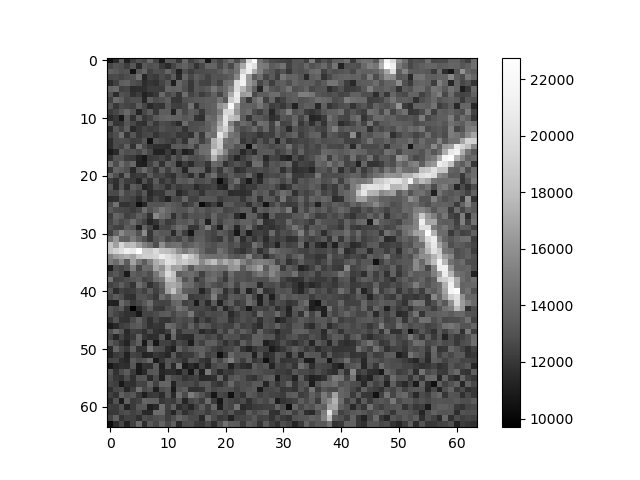
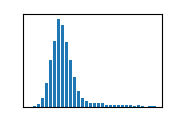

In [7]:
mock_scope.move_stage_to(0, 32, 32) # the image position is given relative to the center of the image, hence (0, 32, 32) is the top right corner of the overview image
print('stage position: ', mock_scope.get_stage_position())
cle.asarray(mock_scope.acquire_image())


## We cannot crash the stage

We get an error when trying to venture outside the safe stage range.

Let's look at the safe stage range:

In [8]:
print('safe stage range (z_range, y_range, x_range): ', mock_scope.stage.z_range, mock_scope.stage.y_range, mock_scope.stage.x_range)

safe stage range (z_range, y_range, x_range):  (0, 11) (32, 480) (32, 480)


We are already at position (0, 31, 31), so if we try to move further up or left, we'll get an error

In [9]:
# moving the stage up by 32 pixels fails because the stage is at the top of the safe range
mock_scope.move_stage_by(relative_y_position=-1)

ValueError: Stage y position 31 out of allowed range: (32, 480)

In [10]:
# moving the stage to position (0, 481, 481) fails because both y and x are outside the safe range
mock_scope.move_stage_to(0, 481, 481)


ValueError: Stage y position 481 out of allowed range: (32, 480)